In [ ]:
from __future__ import annotations
from typing import Optional
import pandas as pd 
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import itertools

warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2

pd.options.display.float_format = "{:,.2f}".format
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)

**Loading**

In [ ]:
# load to dataframe
INFILE = '/home/grace/work/SEER/data/SEERPLUS_2010_2020.clean.tsv'
master = pd.read_csv(INFILE, header=0, sep='\t', na_values='.')

In [ ]:
# NOTE: donor 1037 is annoying. 
master[master['patient_id']==1037]

In [ ]:
from util_funcs import do_basic_formatting
from util_funcs import do_basic_filtering

print('\nBasic filtering')
df = do_basic_filtering(master)

HISTTYPES_PATH = '/home/grace/work/SEER/data/histology/histcodes.tsv'
print('\nBasic formatting')
df = do_basic_formatting(df, HISTTYPES_PATH)

df.head()

**Extra Filtering**

In [ ]:
# print('\nRemoving records for brain primaries')
# irecords = df.shape[0]
# df = df[df['cancer_type']!='Brain']
# print(f'removed {irecords - df.shape[0]} records')

# print('\nRemoving records for CNS cancer_group')
# irecords = df.shape[0]
# df = df[df['cancer_group']!='CNS']
# print(f'removed {irecords - df.shape[0]} records')

# df.head()

**Canonical Trend**

In [ ]:
import os 
from util_classes import Settings
from util_funcs import normalize_field_pergroup
from util_funcs import calculate_bm_prevalence_grouped

CLUSTER_GROUPS   = True
CLUSTER_FEATURES = False

In [ ]:

s = Settings()
groups = ['cancer_group']
features = ['TSTAGE_STD']
groups_subset = None
features_subset = None
response_fields = ['brain_met', 'bone_met', 'lung_met', 'liver_met']

print(f'Groups: {"|".join(groups)}    Features: {"|".join(features)}    Responses: {"|".join(response_fields)}')

tables = []
labels = []

for field in response_fields:
    print(f'Calculating prevalence for "{field}" response')
    # calculate prevalence per group
    maintable = calculate_bm_prevalence_grouped(
        groups=groups, 
        features=features, 
        response_field=field,
        s=s,
        groups_subset=groups_subset,
        features_subset=features_subset,
        df=df
    )
    tables.append(maintable)
    labels.append(field)


In [ ]:
from typing import Any

def _render_celltext_relrisk(rowlabels: list[str], collabels: list[str], s: Settings, maxval: float, table: pd.DataFrame, ax: Any):
    for y, rlabel in enumerate(rowlabels): 
        for x, clabel in enumerate(collabels): 
            # if y < 4:
            #     print(f'x={x}, y={y}, rlabel={rlabel}, clabel={clabel}')
            row = table.loc[(table[s.COMPOUND_GROUP]==rlabel) & (table[s.COMPOUND_FEATURE]==clabel)]
            if row.shape[0] == 0:
                normval, num_bm, num_cases = 0, 0, 0
            else:
                normval = row[s.NORM_FIELD].values[0]
                num_bm = row["YES"].values[0]
                num_cases = row["records"].values[0]
            line1 = f'{normval:0.2f}'
            line2 = f'{num_bm}/{num_cases}'
            color1 = 'white' if normval < (maxval * 0.7) else 'black'
            color2 = color1 if num_cases >= 500 else 'turquoise'
            ax.text(x+0.5, y+0.4, line1, va="center", ha="center", color=color1, fontsize='medium')
            ax.text(x+0.5, y+0.7, line2, va="center", ha="center", color=color2, fontsize='x-small')

In [ ]:

def plot_relrisk_clustermap(
    groups: list[str],
    features: list[str], 
    maintable: pd.DataFrame,
    s: Settings,
    met_label: str='Brain Mets',
    subdir_override: Optional[str]=None,
    ) -> None:

    # normalise prevalence 
    maintable = normalize_field_pergroup(
        groups=s.COMPOUND_GROUP,
        target_field=s.RATE_FIELD, 
        norm_field=s.NORM_FIELD,
        norm_meth=s.NORM_METH,
        df=maintable,
    )

    pivottable = maintable.pivot(index=s.COMPOUND_GROUP, columns=s.COMPOUND_FEATURE, values=s.NORM_FIELD)
    pivottable = pivottable.fillna(0)
    pivottable = pivottable.reindex(sorted(pivottable.columns), axis=1)

    # misc variables
    max_table_value = pivottable.to_numpy().max()
    max_group_label_len = max([len(x) for x in pivottable.index])
    max_feature_label_len = max([len(x) for x in pivottable.columns])
    figx = pivottable.shape[1] // 2 + max_group_label_len // 8 + 1
    figy = pivottable.shape[0] // 1.7 + max_feature_label_len // 8 + 2

    # plot clustermap
    cm = sns.clustermap(
        pivottable, 
        figsize=(figx, figy), 
        cbar_pos=(0.98, 0.6, 0.05, 0.18),
        col_cluster=CLUSTER_FEATURES, 
        row_cluster=CLUSTER_GROUPS, 
        metric="correlation",
        square=True
    )

    # cell text
    rowinds = cm.dendrogram_row.reordered_ind if CLUSTER_GROUPS else list(range(pivottable.shape[0]))
    colinds = cm.dendrogram_col.reordered_ind if CLUSTER_FEATURES else list(range(pivottable.shape[1]))
    rowlabels = [pivottable.index[idx] for idx in rowinds]
    collables = [pivottable.columns[idx] for idx in colinds]
    _render_celltext_relrisk(rowlabels, collables, s, max_table_value, maintable, cm.ax_heatmap)

    # titles & saving
    group_lab = ':'.join(groups)
    feature_lab = ':'.join(features)
    met_lab = met_label.lower().strip('s').replace(' ', '_')
    if subdir_override:
        filepath = f'/home/grace/work/SEER/outputs/clustermaps/{met_lab}/{subdir_override}/{group_lab}_{feature_lab}.png'
    else:
        filepath = f'/home/grace/work/SEER/outputs/clustermaps/{met_lab}/{group_lab}/{feature_lab}.png'
    os.makedirs(filepath.rsplit('/', 1)[0], exist_ok=True)
    
    title = f'{met_label}: {group_lab} vs {feature_lab}'
    cm.ax_heatmap.set_xlabel(feature_lab)
    cm.ax_heatmap.set_ylabel(group_lab)
    plt.suptitle(title)
    plt.savefig(filepath)
    print(filepath)

In [ ]:
from collections import defaultdict
import scipy

def plot_relrisk_clustermap_allmets(
    groups: list[str],
    features: list[str], 
    tables: list[pd.DataFrame],
    labels: list[str],
    s: Settings,
    subdir_override: Optional[str]=None,
    ) -> None:

    assert len(tables) == len(labels)
    CLUSTER_GROUPS   = True
    CLUSTER_FEATURES = False
    
    # normalise prevalence & pivot for each table
    pivot_tables = []
    for table in tables:
        table = normalize_field_pergroup(
            groups=s.COMPOUND_GROUP,
            target_field=s.RATE_FIELD, 
            norm_field=s.NORM_FIELD,
            norm_meth=s.NORM_METH,
            df=table,
        )
        pivottable = table.pivot(index=s.COMPOUND_GROUP, columns=s.COMPOUND_FEATURE, values=s.NORM_FIELD)
        pivottable = pivottable.fillna(0)
        pivottable = pivottable.reindex(sorted(pivottable.columns), axis=1)
        pivot_tables.append(pivottable)

    # plot clustermap for first table to allow clustering
    table1 = pivot_tables[0]
    cm = sns.clustermap(
        table1, 
        col_cluster=CLUSTER_FEATURES, 
        row_cluster=CLUSTER_GROUPS, 
        metric="correlation",
        square=True,
    )
    plt.plot()
    plt.close()

    # get row/col order from clustermap
    rowinds = cm.dendrogram_row.reordered_ind if CLUSTER_GROUPS else list(range(table1.shape[0]))
    colinds = cm.dendrogram_col.reordered_ind if CLUSTER_FEATURES else list(range(table1.shape[1]))
    rowlabels = [table1.index[idx] for idx in rowinds]
    collables = [table1.columns[idx] for idx in colinds]

    # misc variables related to grid aesthetics 
    max_table_value = table1.to_numpy().max()
    max_group_label_len = max([len(x) for x in table1.index])
    max_feature_label_len = max([len(x) for x in table1.columns])
    ncols = table1.shape[1]
    nrows = table1.shape[0]
    figx = ncols // 2 + 1
    figy = nrows // 1.7 + max_feature_label_len // 8 + 2
    
    # subplot for each met type (single row)
    fig, axes = plt.subplots(
        nrows=1, ncols=len(pivot_tables) + 1, 
        figsize=(figx * len(tables) + max_group_label_len // 8 + 1, figy),
        width_ratios=([ncols, ncols, ncols, ncols, 1])
    )
    
    # plot heatmaps & text for all tables using the row/col ordering from clustermap
    i = 0
    for table, table_p, label in zip(tables, pivot_tables, labels):

        # reorder rows & cols correct conformation
        table_p = table_p[collables]
        table_p = table_p.loc[rowlabels]

        # print(f'\n\n---- {i}: {label} ----')
        # print(table_p.head())

        # specify target axes
        ax = axes[i]
        # render heatmap
        sns.heatmap(table_p, cbar=False, ax=ax)
        # render text
        _render_celltext_relrisk(rowlabels, collables, s, max_table_value, table, ax=ax)
        ax.set_title(label)
        ax.set_ylabel('')
        if i >= 1:
            ax.set_yticks([])
            ax.set_yticklabels([])
        i += 1

    # final correlation 1D array
    ax5 = axes[4]
    corr_data = defaultdict(float)
    ntables = len(pivot_tables) - 1
    for rlabel in rowlabels:
        for table_p in pivot_tables[1:]:
            x = table1.loc[rlabel].to_list()
            y = table_p.loc[rlabel].to_list()
            r, pval = scipy.stats.pearsonr(x, y)
            corr_data[rlabel] += r
    for k, v in corr_data.items():
        corr_data[k] = v / ntables
    array1D = pd.DataFrame.from_dict(data=corr_data, orient='index')
    sns.heatmap(array1D, annot=True, cmap='PiYG_r', cbar=False, ax=ax5)
    ax5.set_yticks([])
    ax5.set_yticklabels([])
    ax5.set_xticks([])
    ax5.set_xticklabels([])
    ax5.set_title('Correlation\n(Brain mets vs other mets)')

    # titles & saving
    group_lab = ':'.join(groups)
    feature_lab = ':'.join(features)
    met_labels = '_'.join(labels).replace('_met', '')
    if subdir_override:
        filepath = f'/home/grace/work/SEER/outputs/clustermaps_allmets/{met_labels}/{subdir_override}/{group_lab}_{feature_lab}.png'
    else:
        filepath = f'/home/grace/work/SEER/outputs/clustermaps_allmets/{met_labels}/{group_lab}/{feature_lab}.png'

    os.makedirs(filepath.rsplit('/', 1)[0], exist_ok=True)
    title = f'{group_lab} vs {feature_lab}'
    cm.ax_heatmap.set_xlabel(feature_lab)
    cm.ax_heatmap.set_ylabel(group_lab)
    plt.suptitle(title)
    plt.savefig(filepath)
    print(filepath)

In [ ]:
# print(tables[0].head(16))
# plot_relrisk_clustermap(groups=groups, features=features, s=s, maintable=tables[0])

valid_groups = set(tables[0]['derived_group'].unique())
for table in tables[1:]:
    valid_groups = valid_groups & set(table['derived_group'].unique())
filt_tables = []
for table in tables:
    filt = table[table['derived_group'].isin(valid_groups)]
    filt_tables.append(filt)
    
plot_relrisk_clustermap_allmets(groups=groups, features=features, s=s, labels=labels, tables=filt_tables)

In [ ]:
def _render_celltext_prevalence(rowlabels: list[str], collabels: list[str], s: Settings, maxval: float, table: pd.DataFrame, ax: Any):
    for y, rlabel in enumerate(rowlabels): 
        for x, clabel in enumerate(collabels): 
            row = table.loc[(table[s.COMPOUND_GROUP]==rlabel) & (table[s.COMPOUND_FEATURE]==clabel)]
            if row.shape[0] == 0:
                cases, prev = 0, 0
            else:
                cases = row['YES'].values[0]
                prev = row[s.RATE_FIELD].values[0]
            line1 = f'{cases}'
            line2 = f'{prev:0.1f}%'
            color1 = 'black' if cases < (maxval * 0.7) else 'white'
            color2 = color1
            ax.text(x+0.5, y+0.35, line1, va="center", ha="center", color=color1, fontsize='medium')
            ax.text(x+0.5, y+0.75, line2, va="center", ha="center", color=color2, fontsize='small')

In [ ]:
def plot_relrisk_prev_clustmap(
    groups: list[str],
    features: list[str], 
    maintable: pd.DataFrame,
    s: Settings,
    met_label: str, 
    subdir_override: Optional[str]=None,    
    ) -> None:
    
    CLUSTER_GROUPS   = True
    CLUSTER_FEATURES = False

    # normalise prevalence 
    maintable = normalize_field_pergroup(
        groups=s.COMPOUND_GROUP,
        target_field=s.RATE_FIELD, 
        norm_field=s.NORM_FIELD,
        norm_meth=s.NORM_METH,
        df=maintable,
    )
    
    # create pivot for normalised metric
    table1_pivot = maintable.pivot(index=s.COMPOUND_GROUP, columns=s.COMPOUND_FEATURE, values=s.NORM_FIELD)
    table1_pivot = table1_pivot.fillna(0)
    table1_pivot = table1_pivot.reindex(sorted(table1_pivot.columns), axis=1)
    print()
    print(table1_pivot.head())
    
    # create pivot for prevalence metric
    # table2_pivot = maintable.pivot(index=s.COMPOUND_GROUP, columns=s.COMPOUND_FEATURE, values=s.RATE_FIELD)
    table2_pivot = maintable.pivot(index=s.COMPOUND_GROUP, columns=s.COMPOUND_FEATURE, values='YES')
    table2_pivot = table2_pivot.fillna(0)
    table2_pivot = table2_pivot.reindex(sorted(table2_pivot.columns), axis=1)
    print()
    print(table2_pivot.head())

    # plot clustermap for normalised pivot table to allow clustering
    cm = sns.clustermap(
        table1_pivot, 
        col_cluster=CLUSTER_FEATURES, 
        row_cluster=CLUSTER_GROUPS, 
        metric="correlation",
        square=True,
    )
    plt.plot()
    plt.close()

    # get row/col order from clustermap
    rowinds = cm.dendrogram_row.reordered_ind if CLUSTER_GROUPS else list(range(table1_pivot.shape[0]))
    colinds = cm.dendrogram_col.reordered_ind if CLUSTER_FEATURES else list(range(table1_pivot.shape[1]))
    rowlabels = [table1_pivot.index[idx] for idx in rowinds]
    collables = [table1_pivot.columns[idx] for idx in colinds]
    
    # reorder rows & cols correct conformation in pivot tables
    table1_pivot = table1_pivot[collables]
    table1_pivot = table1_pivot.loc[rowlabels]
    table2_pivot = table2_pivot[collables]
    table2_pivot = table2_pivot.loc[rowlabels]

    # misc variables related to grid aesthetics 
    max_group_label_len = max([len(x) for x in table1_pivot.index])
    max_feature_label_len = max([len(x) for x in table1_pivot.columns])
    figx = table1_pivot.shape[1] // 2 + 1
    figy = table1_pivot.shape[0] // 1.7 + max_feature_label_len // 8 + 2
    
    # subplots: ax1=normalised, ax2=prevalence
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(figx * 2 + max_group_label_len // 8, figy))
    
    # ax1=normalised
    max_table_value = table1_pivot.to_numpy().max()
    sns.heatmap(table1_pivot, cbar=False, ax=axes[0])
    _render_celltext_relrisk(rowlabels, collables, s, max_table_value, maintable, ax=axes[0])
    axes[0].set_ylabel('')
    axes[0].set_title('Relative Risk')
    
    # ax2=prevalence
    max_table_value = table2_pivot.drop('Lung and Bronchus').to_numpy().max()
    # max_table_value = min(max_table_value, 5000)
    sns.heatmap(table2_pivot, cbar=False, ax=axes[1], vmax=max_table_value, cmap='rocket_r')
    _render_celltext_prevalence(rowlabels, collables, s, max_table_value, maintable, ax=axes[1])
    axes[1].set_ylabel('')
    axes[1].set_yticks([])
    axes[1].set_yticklabels([])
    axes[1].set_title('Case load')

    # titles & saving
    group_lab = ':'.join(groups)
    feature_lab = ':'.join(features)
    if subdir_override:
        filepath = f'/home/grace/work/SEER/outputs/heatmaps_dual/{met_label}/{subdir_override}/{group_lab}_{feature_lab}.png'
    else:
        filepath = f'/home/grace/work/SEER/outputs/heatmaps_dual/{met_label}/{group_lab}/{feature_lab}.png'

    os.makedirs(filepath.rsplit('/', 1)[0], exist_ok=True)
    title = f'{group_lab} vs {feature_lab}'
    cm.ax_heatmap.set_xlabel(feature_lab)
    cm.ax_heatmap.set_ylabel(group_lab)
    plt.suptitle(title)
    plt.savefig(filepath)
    print(filepath)


In [ ]:
tables[0].head()
plot_relrisk_prev_clustmap(groups=groups, features=features, s=s, met_label='brain_met', maintable=tables[0])

In [288]:
def plot_relrisk_prev_clustmap_improved(
    groups: list[str],
    features: list[str], 
    maintable: pd.DataFrame,
    s: Settings,
    met_label: str, 
    subdir_override: Optional[str]=None,    
    ) -> None:
    
    CLUSTER_GROUPS   = True
    CLUSTER_FEATURES = False

    # normalise prevalence 
    maintable = normalize_field_pergroup(
        groups=s.COMPOUND_GROUP,
        target_field=s.RATE_FIELD, 
        norm_field=s.NORM_FIELD,
        norm_meth=s.NORM_METH,
        df=maintable,
    )
    
    # create pivot for normalised metric
    table1_pivot = maintable.pivot(index=s.COMPOUND_GROUP, columns=s.COMPOUND_FEATURE, values=s.NORM_FIELD)
    table1_pivot = table1_pivot.fillna(0)
    table1_pivot = table1_pivot.reindex(sorted(table1_pivot.columns), axis=1)
    
    # create pivot for prevalence metric
    # table2_pivot = maintable.pivot(index=s.COMPOUND_GROUP, columns=s.COMPOUND_FEATURE, values=s.RATE_FIELD)
    table2_pivot = maintable.pivot(index=s.COMPOUND_GROUP, columns=s.COMPOUND_FEATURE, values='YES')
    table2_pivot = table2_pivot.fillna(0)
    table2_pivot = table2_pivot.reindex(sorted(table2_pivot.columns), axis=1)

    # plot clustermap for normalised pivot table to allow clustering
    cm = sns.clustermap(
        table1_pivot, 
        col_cluster=CLUSTER_FEATURES, 
        row_cluster=CLUSTER_GROUPS, 
        metric="correlation",
        square=True,
    )
    plt.plot()
    plt.close()

    # get row/col order from clustermap
    rowinds = cm.dendrogram_row.reordered_ind if CLUSTER_GROUPS else list(range(table1_pivot.shape[0]))
    colinds = cm.dendrogram_col.reordered_ind if CLUSTER_FEATURES else list(range(table1_pivot.shape[1]))
    rowlabels = [table1_pivot.index[idx] for idx in rowinds]
    collables = [table1_pivot.columns[idx] for idx in colinds]
    
    # reorder rows & cols correct conformation in pivot tables
    table1_pivot = table1_pivot[collables]
    table1_pivot = table1_pivot.loc[rowlabels]
    table2_pivot = table2_pivot[collables]
    table2_pivot = table2_pivot.loc[rowlabels]

    # misc variables related to grid aesthetics 
    max_group_label_len = max([len(x) for x in table1_pivot.index])
    max_feature_label_len = max([len(x) for x in table1_pivot.columns])
    figx = table1_pivot.shape[1] // 2 + 1
    figy = table1_pivot.shape[0] // 1.7 + max_feature_label_len // 8 + 2
    
    # subplots: ax1=normalised, ax2=prevalence
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(figx * 2 + max_group_label_len // 8, figy))
    
    # ax1=normalised
    ax1 = axes[0]
    max_table_value = table1_pivot.to_numpy().max()
    sns.heatmap(table1_pivot, cbar=False, ax=ax1)
    _render_celltext_relrisk(rowlabels, collables, s, max_table_value, maintable, ax=ax1)
    ax1.set_ylabel('')
    ax1.set_title('Relative Risk')
    
    # ax2=prevalence
    sns.set_theme(style="whitegrid")
    ax2 = axes[1]
    totals = table2_pivot.sum(axis=1).reset_index()
    totals.columns = ['derived_group', 'cases']
    colors = sns.color_palette("pastel")
    for i, (clabel, color) in enumerate(zip(reversed(collables), colors)):
        # print()
        # print(i, clabel)
        # print(totals.head())
        g = sns.barplot(x='cases', y='derived_group', data=totals, color=color, label=clabel, ax=ax2, orient="y")
        totals['cases'] = totals['cases'] - table2_pivot.loc[:, clabel].values
    ax2.set_ylabel('')
    ax2.set_yticks([])
    ax2.set_yticklabels([])
    ax2.set_title('Case load')
    # ax2.set_xlabel('Brain Met Cases')
    ax2.set_xlabel('log(Brain Met Cases)')
    ax2.set_xscale('log')
    sns.despine(left=True, bottom=True)

    # g = sns.barplot(x="records", y=FEATURE, data=table2_pivot, label="Case Load", ax=axes[1])
    # max_table_value = table2_pivot.drop('Lung and Bronchus').to_numpy().max()
    # # max_table_value = min(max_table_value, 5000)
    # sns.heatmap(table2_pivot, cbar=False, ax=axes[1], vmax=max_table_value, cmap='rocket_r')
    # _render_celltext_prevalence(rowlabels, collables, s, max_table_value, maintable, ax=axes[1])
    # axes[1].set_ylabel('')
    # axes[1].set_yticks([])
    # axes[1].set_yticklabels([])
    # axes[1].set_title('Case load')

    # titles & saving
    group_lab = ':'.join(groups)
    feature_lab = ':'.join(features)
    if subdir_override:
        filepath = f'/home/grace/work/SEER/outputs/heatmaps_dual/{met_label}/{subdir_override}/{group_lab}_{feature_lab}_bar_log.png'
    else:
        filepath = f'/home/grace/work/SEER/outputs/heatmaps_dual/{met_label}/{group_lab}/{feature_lab}_bar_log.png'

    os.makedirs(filepath.rsplit('/', 1)[0], exist_ok=True)
    title = f'{group_lab} vs {feature_lab}'
    cm.ax_heatmap.set_xlabel(feature_lab)
    cm.ax_heatmap.set_ylabel(group_lab)
    plt.suptitle(title)
    plt.savefig(filepath)
    print(filepath)


/home/grace/work/SEER/outputs/heatmaps_dual/brain_met/cancer_group/TSTAGE_STD_bar_log.png


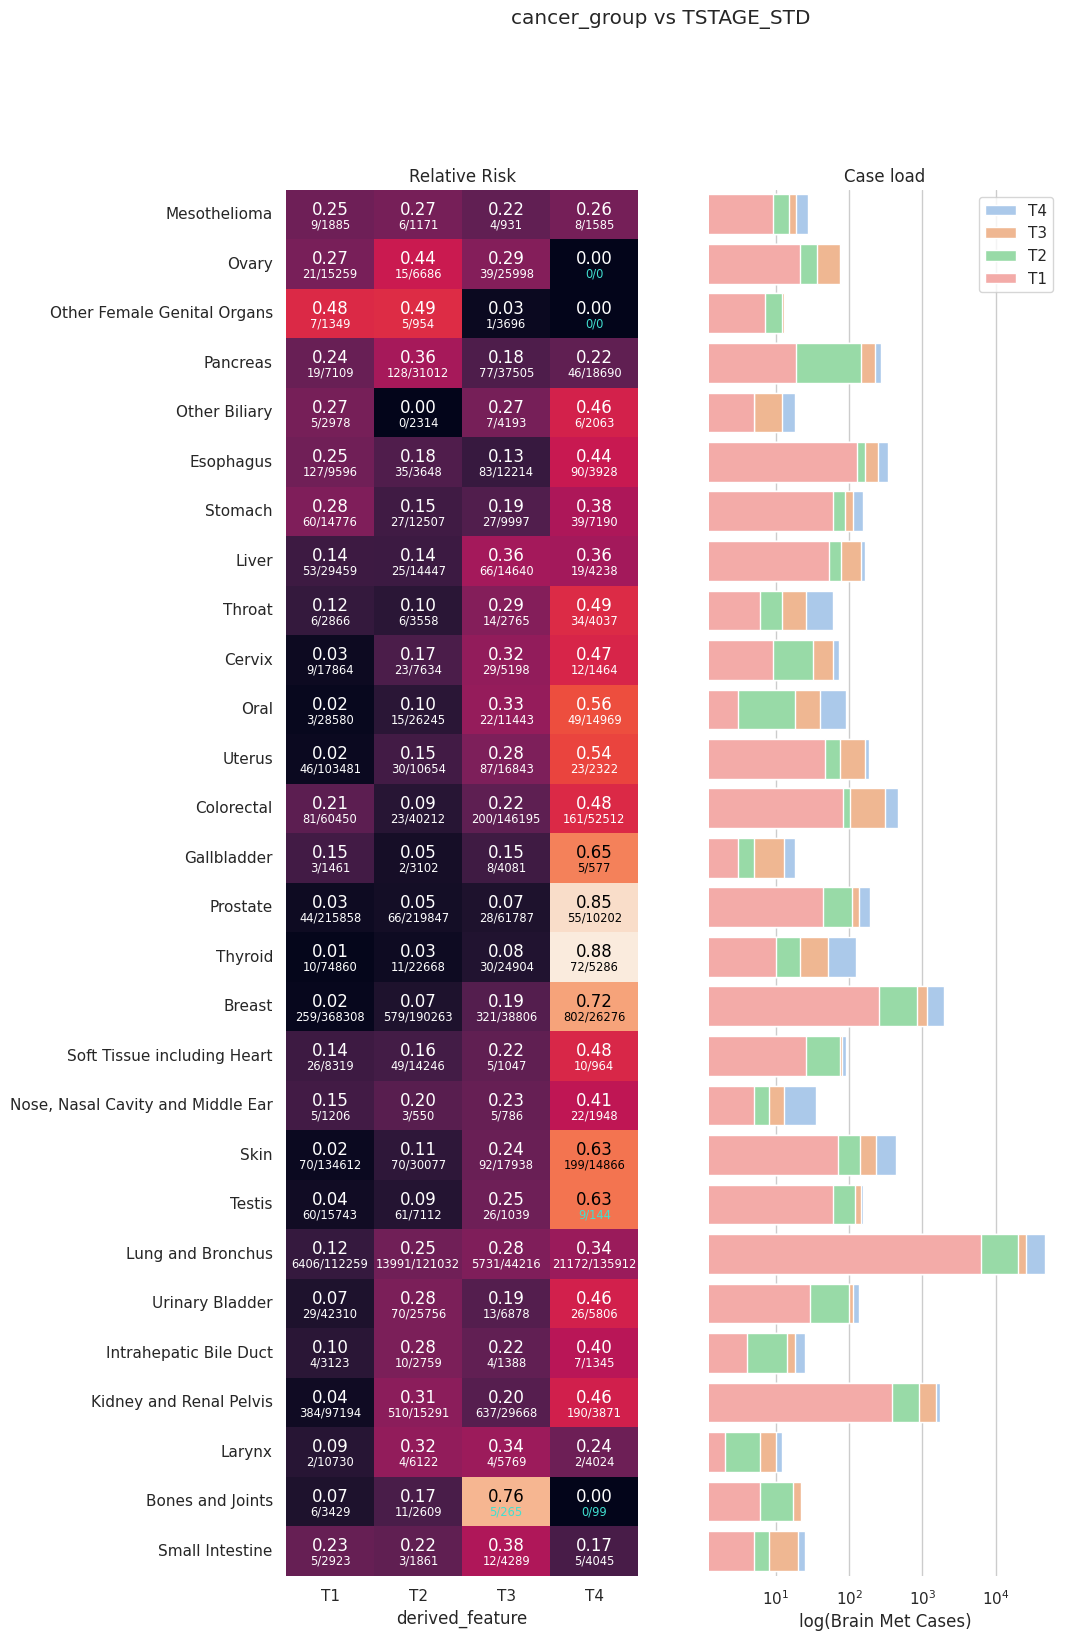

In [289]:
tables[0].head()
plot_relrisk_prev_clustmap_improved(groups=groups, features=features, s=s, met_label='brain_met', maintable=tables[0])

    day  total_bill
0  Thur    1,096.33
1   Fri      325.88
2   Sat    1,778.40
3   Sun    1,627.16
     total_bill  tip     sex smoker  day    time  size
56        38.01 3.00    Male    Yes  Sat  Dinner     4
58        11.24 1.76    Male    Yes  Sat  Dinner     2
60        20.29 3.21    Male    Yes  Sat  Dinner     2
61        13.81 2.00    Male    Yes  Sat  Dinner     2
62        11.02 1.98    Male    Yes  Sat  Dinner     2
..          ...  ...     ...    ...  ...     ...   ...
234       15.53 3.00    Male    Yes  Sat  Dinner     2
236       12.60 1.00    Male    Yes  Sat  Dinner     2
237       32.83 1.17    Male    Yes  Sat  Dinner     2
240       27.18 2.00  Female    Yes  Sat  Dinner     2
241       22.67 2.00    Male    Yes  Sat  Dinner     2

[93 rows x 7 columns]


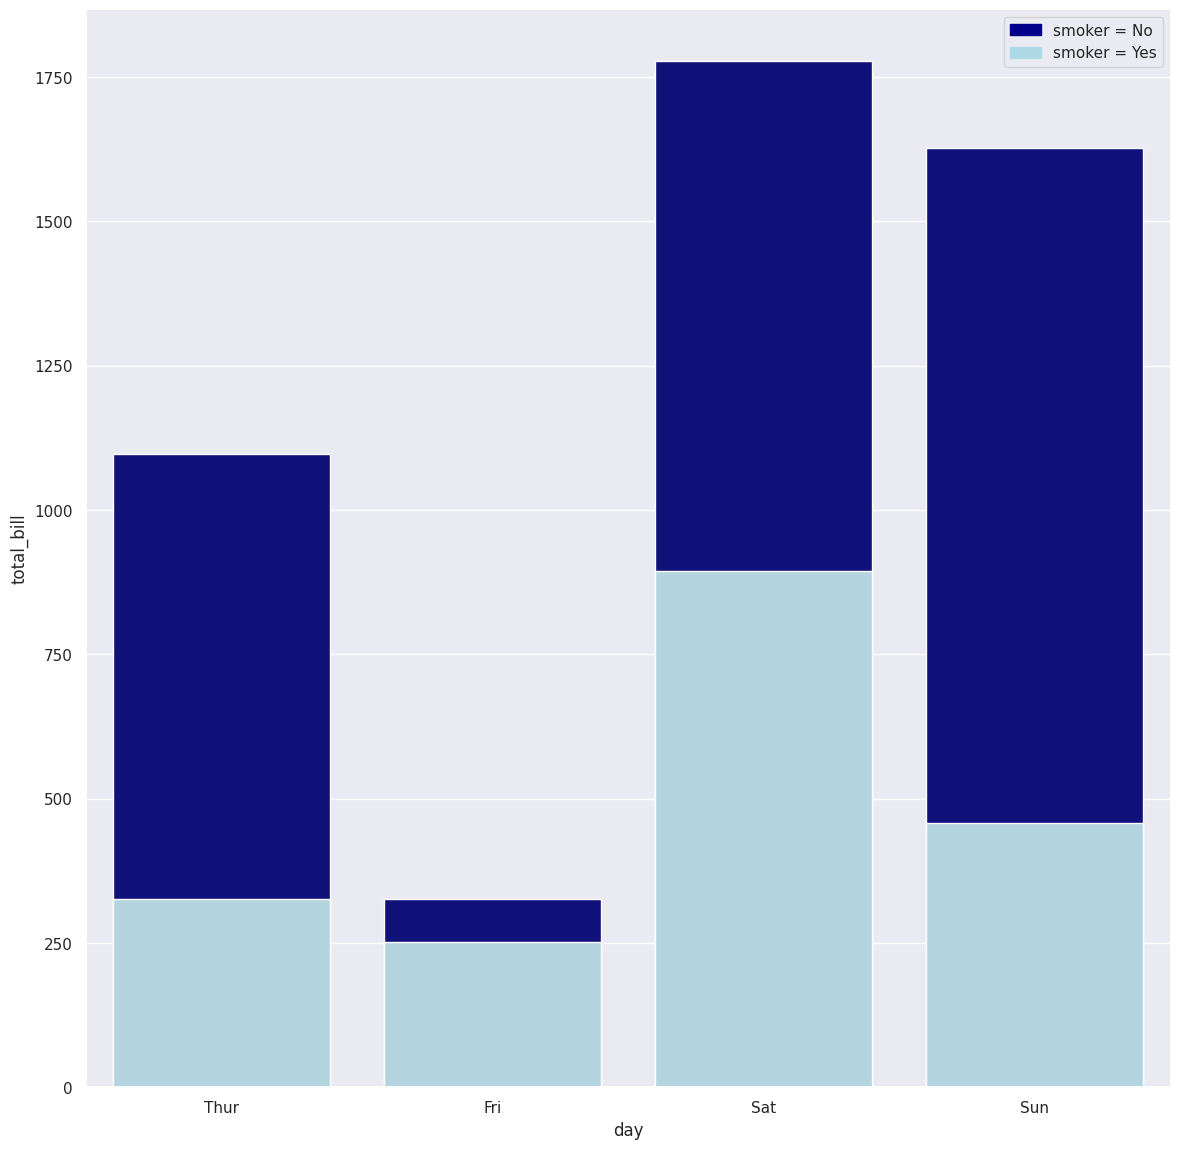

In [210]:
# import libraries
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# load dataset
tips = sns.load_dataset("tips")

# set plot style: grey grid in the background:
sns.set_theme(style="darkgrid")

# set the figure size
plt.figure(figsize=(14, 14))

# top bar -> sum all values(smoker=No and smoker=Yes) to find y position of the bars
total = tips.groupby('day')['total_bill'].sum().reset_index()
print(total)

# bar chart 1 -> top bars (group of 'smoker=No')
bar1 = sns.barplot(x="day",  y="total_bill", data=total, color='darkblue')

# bottom bar ->  take only smoker=Yes values from the data
smoker = tips[tips.smoker=='Yes']
print(smoker)

# bar chart 2 -> bottom bars (group of 'smoker=Yes')
bar2 = sns.barplot(x="day", y="total_bill", data=smoker, estimator=sum, ci=None,  color='lightblue')

# add legend
top_bar = mpatches.Patch(color='darkblue', label='smoker = No')
bottom_bar = mpatches.Patch(color='lightblue', label='smoker = Yes')
plt.legend(handles=[top_bar, bottom_bar])

# show the graph
plt.show()

In [ ]:

def do_clustermap(
    groups: list[str],
    features: list[str], 
    response_fields: list[str],
    df: pd.DataFrame, 
    s: Settings,
    groups_subset: Optional[dict]=None, 
    features_subset: Optional[dict]=None,
    subdir_override: Optional[str]=None,
    ) -> None:
        
    print(f'Groups: {":".join(groups)}    Features: {":".join(features)}    Responses: {":".join(response_fields)}')

    pivot_tables = []
    pivot_labels = []

    for field in response_fields:
        # calculate prevalence per group
        maintable = calculate_bm_prevalence_grouped(
            groups=groups, 
            features=features, 
            response_field=field,
            s=s,
            groups_subset=groups_subset,
            features_subset=features_subset,
            df=df
        )
        
        # normalise prevalence 
        maintable = normalize_field_pergroup(
            groups=s.COMPOUND_GROUP,
            target_field=s.RATE_FIELD, 
            norm_field=s.NORM_FIELD,
            norm_meth=s.NORM_METH,
            df=maintable,
        )

        maintable_p = maintable.pivot(index=s.COMPOUND_GROUP, columns=s.COMPOUND_FEATURE, values=s.NORM_FIELD)
        maintable_p = maintable_p.fillna(0)
        maintable_p = maintable_p.reindex(sorted(maintable_p.columns), axis=1)
        pivot_tables.append(maintable_p)
        pivot_labels.append(field)

    plot_clustmap(
        groups=groups,
        features=features,
        pivot_tables=pivot_tables,
        pivot_labels=pivot_labels,
        s=s,
        subdir_override=subdir_override
    )


In [ ]:

def do_all_clustermaps(
    group_fields: list[str], 
    feature_fields: list[str], 
    response_field: str,
    s: Settings,
    df: pd.DataFrame, 
    subdir_override: Optional[str]=None) -> None:
    # single group vs single feature
    print('\nOne group, one feature')
    min_records = 1000
    for gfield in group_fields:
        for ffield in feature_fields:
            gfields = [gfield]
            ffields = [ffield]
            plot_clustmap(
                groups=gfields, 
                features=ffields, 
                response_field=response_field, 
                min_records=min_records, 
                df=df, 
                s=s, 
                features_subset={'GRADE_STD': ['G1', 'G2', 'G3', 'G4']}, subdir_override=subdir_override
            )

    # single group vs two features
    if len(feature_fields) > 1:
        print('\nOne group, two features')
        min_records = 5000
        for gfield in group_fields:
            for ffields in itertools.combinations(feature_fields, 2):
                gfields = [gfield]
                ffields = list(ffields)
                plot_clustmap(
                    groups=gfields, 
                    features=ffields, 
                    response_field=response_field, 
                    min_records=min_records, 
                    df=df, 
                    s=s, 
                    features_subset={'GRADE_STD': ['G1', 'G2', 'G3', 'G4']}, subdir_override=subdir_override
                )

    # two groups vs single feature
    if len(group_fields) > 1:
        print('\nTwo groups, single feature')
        min_records = 1000
        for ffield in feature_fields:
            ffields = [ffield]
            plot_clustmap(
                groups=group_fields, 
                features=ffields, 
                response_field=response_field, 
                min_records=min_records, 
                df=df, 
                s=s, 
                features_subset={'GRADE_STD': ['G1', 'G2', 'G3', 'G4']}, subdir_override=subdir_override
            )
        # two groups vs two features
        if len(feature_fields) > 1:
            print('\nTwo groups, two features')
            min_records = 5000
            for ffields in itertools.combinations(feature_fields, 2):
                ffields = list(ffields)
                plot_clustmap(
                    groups=group_fields, 
                    features=ffields, 
                    response_field=response_field, 
                    min_records=min_records, 
                    df=df, 
                    s=s, 
                    features_subset={'GRADE_STD': ['G1', 'G2', 'G3', 'G4']}, subdir_override=subdir_override
                )


In [ ]:

settings = Settings()
RESPONSE_FIELD = 'brain_met'

###############
### GENERAL ###
###############
print('\n\n--- GENERAL ---\n')
do_all_clustermaps(
    group_fields=['cancer_group', 'hist_cateogry'], 
    feature_fields=['GRADE_STD', 'NSTAGE_STD', 'TSTAGE_STD'], 
    response_field=RESPONSE_FIELD,
    s=settings,
    df=df
)

##############
### BREAST ###
##############
print('\n\n--- BREAST ---\n')
breast_df = df[df['cancer_group']=='Breast']

do_all_clustermaps(
    group_fields=['breast_subtype', 'hist_cateogry'], 
    feature_fields=['GRADE_STD', 'NSTAGE_STD', 'TSTAGE_STD'], 
    response_field=RESPONSE_FIELD,
    s=settings,
    df=breast_df,
    subdir_override='breast'
)

################
### PROSTATE ###
################
print('\n\n--- PROSTATE ---\n')
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
prostate_df = df[df['cancer_group']=='Prostate']
prostate_df['psa_bin'] = pd.cut(prostate_df['psa'], bins).astype(str)

# PSA value to bins
do_all_clustermaps(
    group_fields=['hist_cateogry', 'hist_type_descr'], 
    feature_fields=['psa_bin'], 
    response_field=RESPONSE_FIELD,
    s=settings,
    df=prostate_df,
    subdir_override='prostate'
)
do_all_clustermaps(
    group_fields=['psa_bin'], 
    feature_fields=['GRADE_STD', 'NSTAGE_STD', 'TSTAGE_STD'], 
    response_field=RESPONSE_FIELD,
    s=settings,
    df=prostate_df,
    subdir_override='prostate'
)


In [ ]:
NSTAGE_IGNORES = [
    'NHL - Extranodal', 
    'NHL - Nodal', 
    'Hodgkin - Extranodal', 
    'Hodgkin - Nodal'
]
N0N1_OVERRIDES = ['Pancreas', 'Other Biliary']


<br>
<br>
<br>
<br>
<br>
<br>
<br>